![Colab](https://www.tensorflow.org/images/colab_logo_32px.png) [Run in Google Colab](https://colab.research.google.com/drive/1O-FeZF6_KFn3WTswx-zcbkWtqyL4Tfvn?usp=sharing) ![GitHub](https://www.tensorflow.org/images/GitHub-Mark-32px.png) [View source on GitHub](https://github.com/TanyaYu/Curriculum-Project/blob/master/module3/Residual_Neural_Network_(ResNet).ipynb)

# Residual Neural Network (ResNet)

According to the universal approximation theorem, given enough capacity, we know that a feedforward network with a single layer is sufficient to represent any function. However, the layer might be massive and the network is prone to overfitting the data. Therefore, there is a common trend in the research community that our network architecture needs to go deeper.

However, increasing network depth does not work by simply stacking layers together. Deep networks are hard to train because of the notorious vanishing gradient problem — as the gradient is back-propagated to earlier layers, repeated multiplication may make the gradient infinitely small. As a result, as the network goes deeper, its performance gets saturated or even starts degrading rapidly.

![CIFAR-10 train error](https://miro.medium.com/max/1400/1*McwAbGJjA1lV_xBdg1w5XA.png)

*Figure 1. Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “plain” networks. The deeper network has higher training error, and thus test error.*

Amongst the many theories explaining why Deeper Networks fail to perform better than their Shallow counterparts, it is sometimes better to look for empirical results for explanation and work backwards from there. The problem of training very deep networks has been alleviated with the introduction of a new neural network layer — **The Residual Block**, or also called **The Identity Block**.

The most important modification to understand is the ‘Skip Connection’, identity mapping. This identity mapping does not have any parameters and is just there to add the output from the previous layer to the layer ahead.

![a residual block](https://miro.medium.com/max/816/1*ByrVJspW-TefwlH7OLxNkg.png)

*Figure 2. A residual block*

Stacking layers shouldn’t degrade the network performance, because we could simply stack identity mappings (layer that doesn’t do anything) upon the current network, and the resulting architecture would perform the same. This indicates that the deeper model should not produce a training error higher than its shallower counterparts. They hypothesize that letting the stacked layers fit a residual mapping is easier than letting them directly fit the desired underlying mapping. And the residual block above explicitly allows it to do precisely that.

![resnet train error](https://miro.medium.com/max/1400/0*AMK5ylLHQQ3CLQzk)

*Figure 3. Training Results of the Architectures. The straight line depicts training error and the static line depicts testing error. The 34-layer ResNet achieves sub 30% error rate, unlike the Plain Network on the left plot. The 34-Layer ResNet outperforms the 18-Layer ResNet by 2.8%.*

![resrnet50](https://miro.medium.com/max/1232/0*Si4ckM1MrkUxTaDH)

*Figure 4. The ResNet architecture*

### References:
1. [Deep Residual Learning for Image Recognition
](https://arxiv.org/pdf/1512.03385.pdf)
2. [Introduction to ResNets](https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4)
3. [An Overview of ResNet and its Variants](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)



# Import Libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Add
from tensorflow.keras.layers import Input, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import get_file
from os.path import join, dirname, basename
from sklearn.model_selection import train_test_split
import pandas as pd
import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


# Data Preprocessing

In [3]:
url = 'https://storage.googleapis.com/vehicle-dataset/vehicles_5k.zip'
path_to_zip = get_file('vehicles_5k.zip', origin=url, extract=True)
path = join(dirname(path_to_zip), 'vehicles_5k')

97263616/97261988 [==============================] - 3s 0us/step


In [4]:
files = glob.glob(path + '/*/*', recursive=True)
  
X = files
y = [basename(dirname(f)) for f in files]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({"filename": X_train, "class": y_train}) 
test_df = pd.DataFrame({"filename": X_test, "class": y_test}) 

In [5]:
IMG_HEIGHT = 32 
IMG_WIDTH = 64
batch_size = 128

In [6]:
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) 
train_data_gen = image_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col="filename",
                                                     y_col="class",
                                                     subset="training",
                                                     shuffle=True,
                                                     seed=42,
                                                     batch_size=batch_size,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")
valid_data_gen = image_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col="filename",
                                                     y_col="class",
                                                     subset="validation",
                                                     shuffle=True,
                                                     seed=42,
                                                     batch_size=batch_size,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")

Found 3200 validated image filenames belonging to 6 classes.
Found 799 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Create Model

## Simple ResNet

In this section, we are going to implement a simple residual neural network architecture from scratch. We'll build the model from blocks of two types: convolutional block `conv_block` and identity block `identity_block` (aka residual block). 

**Convolution block** consists of 3 convolutional layers and has another convolution layer at a shortcut. 

**Identity block** also has 3 convolutional layers but it doesn't have a layer at shortcut (it skips connection).

**Batch normalization** is often used in residual network architecture. It reduces overfitting and improves training speed. Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift) by adjusting and scaling the activations. Note that the values must be normalized *before* activation. `Conv2DWithBatchNorm` function is an example of applying batch norm to convolutional layer that we are going to use in our network.

Simple ResNet implementation is demonstrated bellow. This code was partially retrieved from [Keras ResNet50 source code](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) and simplified for learning purposes. Note, that a simplified model might not be faster or more effective than the original ResNet50.

In [7]:
def Conv2DWithBatchNorm(inputs, filters, kernel_size, padding='same', activation=None, kernel_initializer='glorot_uniform'):
    """Conv2D followed by BatchNormalization before activation"""
    x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization()(x)
    if activation is not None:
      x = Activation(activation)(x)
    return x


def identity_block(input_tensor, filters):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters

    x = Conv2DWithBatchNorm(input_tensor, filters1, 1, activation='relu', kernel_initializer='he_normal')
    x = Conv2DWithBatchNorm(x, filters2, 3, activation='relu', kernel_initializer='he_normal')
    x = Conv2DWithBatchNorm(x, filters3, 1, activation=None, kernel_initializer='he_normal')

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, filters):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters

    x = Conv2DWithBatchNorm(input_tensor, filters1, 1, activation='relu', kernel_initializer='he_normal')
    x = Conv2DWithBatchNorm(x, filters2, 3, activation='relu', kernel_initializer='he_normal')
    x = Conv2DWithBatchNorm(x, filters3, 1, activation=None, kernel_initializer='he_normal')

    shortcut = Conv2DWithBatchNorm(input_tensor, filters3, 1, activation=None, kernel_initializer='he_normal')

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [8]:
def create_simple_resnet():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

  x = Conv2DWithBatchNorm(inputs, 32, 3, activation='relu', kernel_initializer='he_normal')

  x = conv_block(x, [32, 32, 128]) # first layer of this block has 32 neurons, second - 32, third - 128
  x = identity_block(x, [32, 32, 128])
  x = identity_block(x, [32, 32, 128])

  x = conv_block(x, [64, 64, 256])
  x = identity_block(x, [64, 64, 256])
  x = identity_block(x, [64, 64, 256])

  x = GlobalAveragePooling2D()(x)
  x = Dense(128)(x)
  x = Dense(6)(x)
  x = Activation('softmax')(x)

  return Model(inputs, x, name='resnet')

In [9]:
simple_resnet = create_simple_resnet()

In [10]:
simple_resnet.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________________

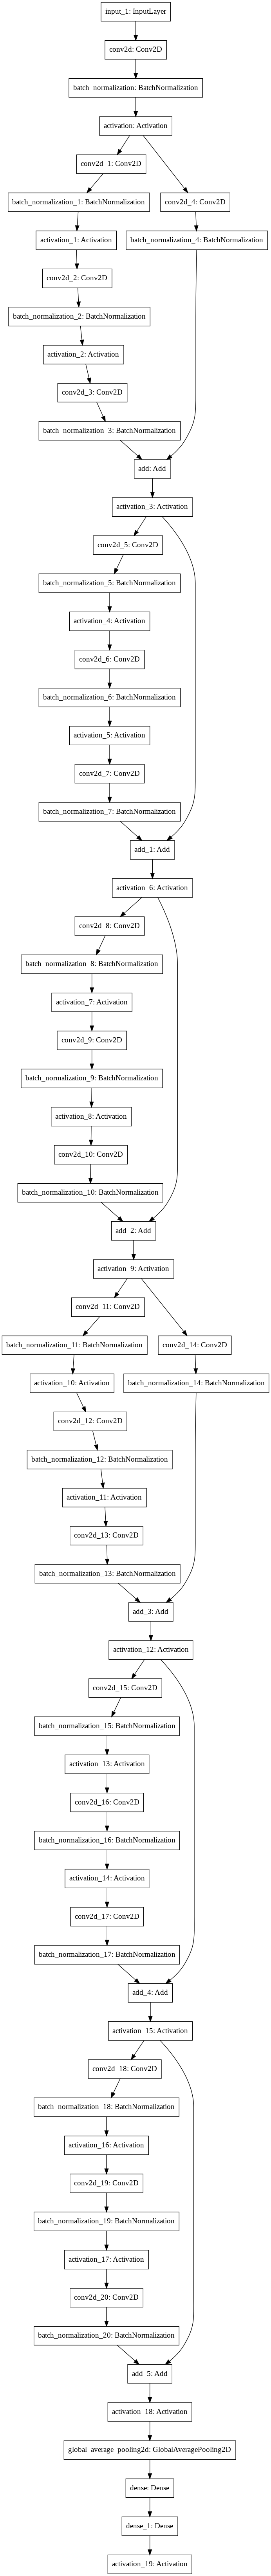

In [11]:
plot_model(simple_resnet)

## ResNet50
Residual neural network with 50 layers implemented by Keras.

In [12]:
from tensorflow.keras.applications import ResNet50

In [13]:
def create_resnet50():
  model_top = ResNet50(
      include_top=False,
      weights=None,
      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
  x = GlobalAveragePooling2D()(model_top.output)  
  x = Dropout(0.2)(x)
  x = Dense(128)(x)
  x = Dense(6)(x)
  x = Activation('softmax')(x)
  return Model(model_top.input, x, name='resnet50')

In [14]:
resnet50 = create_resnet50()

In [15]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

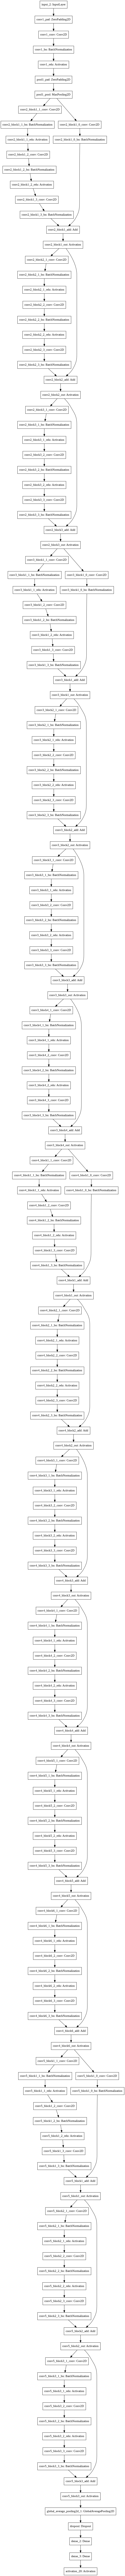

In [16]:
plot_model(resnet50)

# Train

In [17]:
def plot_training_history(h):
    acc = h.history['accuracy']
    loss = h.history['loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if 'val_accuracy' in h.history:
        val_acc = h.history['val_accuracy']
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if 'val_loss' in h.history:
        val_loss = h.history['val_loss']
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

## Simple ResNet

In [18]:
simple_resnet.compile(optimizer=Adam(lr=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
history_simple_resnet = simple_resnet.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=20,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
25/25 [==============================] - 9s 372ms/step - loss: 2.0541 - accuracy: 0.3006 - val_loss: 2.4582 - val_accuracy: 0.2716
Epoch 2/20
25/25 [==============================] - 8s 336ms/step - loss: 1.2850 - accuracy: 0.4941 - val_loss: 1.8516 - val_accuracy: 0.2278
Epoch 3/20
25/25 [==============================] - 8s 337ms/step - loss: 1.1539 - accuracy: 0.5334 - val_loss: 1.9604 - val_accuracy: 0.2403
Epoch 4/20
25/25 [==============================] - 8s 338ms/step - loss: 1.0523 - accuracy: 0.5831 - val_loss: 2.2737 - val_accuracy: 0.2441
Epoch 5/20
25/25 [==============================] - 8s 339ms/step - loss: 0.9766 - accuracy: 0.6225 - val_loss: 2.6563 - val_accuracy: 0.2478
Epoch 6/20
25/25 [==============================] - 9s 341ms/step - loss: 0.9182 - accuracy: 0.6391 - val_loss: 2.8224 - val_accuracy: 0.2566
Epoch 7/20
25/25 [==============================] - 8s 340ms/step - loss

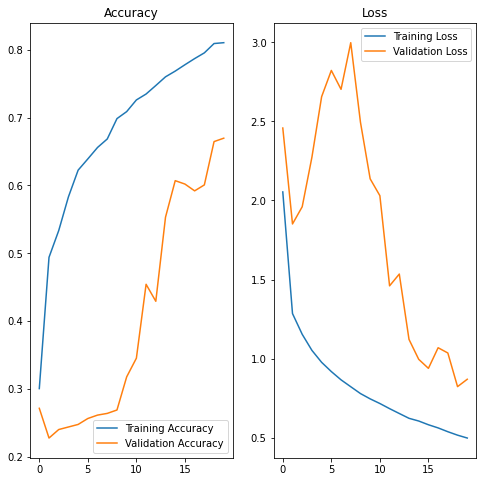

In [20]:
plot_training_history(history_simple_resnet)

## ResNet50

In [46]:
resnet50.compile(optimizer=Adam(lr=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [47]:
history_resnet50 = resnet50.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=20,
)

Epoch 1/20
25/25 [==============================] - 3s 126ms/step - loss: 2.5132 - accuracy: 0.2728 - val_loss: 1.7282 - val_accuracy: 0.2390
Epoch 2/20
25/25 [==============================] - 2s 94ms/step - loss: 2.0444 - accuracy: 0.3531 - val_loss: 1.7778 - val_accuracy: 0.2390
Epoch 3/20
25/25 [==============================] - 2s 94ms/step - loss: 1.6392 - accuracy: 0.4322 - val_loss: 1.7508 - val_accuracy: 0.2390
Epoch 4/20
25/25 [==============================] - 2s 94ms/step - loss: 1.4372 - accuracy: 0.4944 - val_loss: 1.8839 - val_accuracy: 0.2390
Epoch 5/20
25/25 [==============================] - 2s 94ms/step - loss: 1.2321 - accuracy: 0.5612 - val_loss: 1.9795 - val_accuracy: 0.2390
Epoch 6/20
25/25 [==============================] - 2s 94ms/step - loss: 1.0603 - accuracy: 0.6291 - val_loss: 2.0303 - val_accuracy: 0.2390
Epoch 7/20
25/25 [==============================] - 2s 95ms/step - loss: 0.9054 - accuracy: 0.6916 - val_loss: 2.0334 - val_accuracy: 0.2403
Epoch 8/20
2

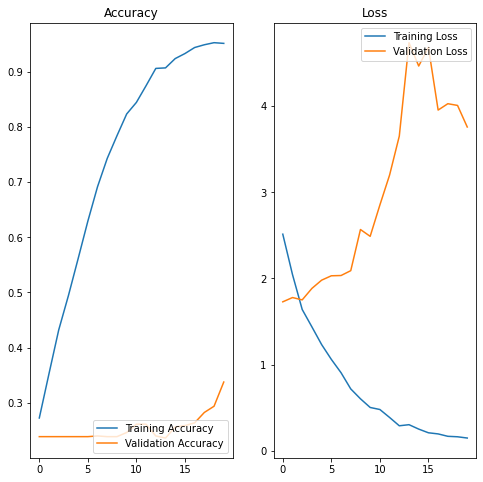

In [48]:
plot_training_history(history_resnet50)

# Evaluate

In [24]:
image_generator = ImageDataGenerator(rescale=1./255) 
test_data_gen = image_generator.flow_from_dataframe(dataframe=test_df,
                                                    x_col="filename",
                                                    y_col="class",
                                                    shuffle=False,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    class_mode="categorical")

Found 1000 validated image filenames belonging to 6 classes.


In [25]:
def evaluate_model(m):
    train_eval = m.evaluate_generator(train_data_gen)
    valid_eval = m.evaluate_generator(valid_data_gen)
    test_eval = m.evaluate_generator(test_data_gen)
    print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f' % (train_eval[1]*100, train_eval[0]))
    print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f' % (valid_eval[1]*100, valid_eval[0]))
    print('Test Accuracy      : %1.2f%%     Test loss      : %1.6f' % (test_eval[1]*100, test_eval[0]))

## Simple ResNet

In [26]:
evaluate_model(simple_resnet)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Training Accuracy  : 70.94%     Training loss  : 0.684515
Validation Accuracy: 66.96%     Validation loss: 0.869619
Test Accuracy      : 65.80%     Test loss      : 0.840381


## ResNet50

In [49]:
evaluate_model(resnet50)

Training Accuracy  : 37.06%     Training loss  : 3.348520
Validation Accuracy: 33.79%     Validation loss: 3.756891
Test Accuracy      : 33.90%     Test loss      : 3.461092


# Exercises

## Exercise 1
By looking at the training results we can notice that 20 epochs are not enough to train a ResNet. But how long exactly should we train the model before it starts overfitting? Instead of guessing we could use `EarlyStopping` callback that will terminate training just before overfitting. 

For this exercise implement `EarlyStopping` in one of the models and compare training results.

In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

Epoch 1/100
25/25 [==============================] - 9s 353ms/step - loss: 1.5431 - accuracy: 0.3456 - val_loss: 5.7903 - val_accuracy: 0.1827
Epoch 2/100
25/25 [==============================] - 9s 341ms/step - loss: 1.2485 - accuracy: 0.4784 - val_loss: 2.5204 - val_accuracy: 0.0851
Epoch 3/100
25/25 [==============================] - 9s 342ms/step - loss: 1.1184 - accuracy: 0.5397 - val_loss: 1.9916 - val_accuracy: 0.2315
Epoch 4/100
25/25 [==============================] - 9s 343ms/step - loss: 1.0312 - accuracy: 0.5881 - val_loss: 2.1651 - val_accuracy: 0.2466
Epoch 5/100
25/25 [==============================] - 9s 344ms/step - loss: 0.9549 - accuracy: 0.6125 - val_loss: 2.3979 - val_accuracy: 0.2466
Epoch 6/100
25/25 [==============================] - 9s 345ms/step - loss: 0.8943 - accuracy: 0.6397 - val_loss: 2.5200 - val_accuracy: 0.2491
Epoch 7/100
25/25 [==============================] - 9s 346ms/step - loss: 0.8428 - accuracy: 0.6628 - val_loss: 2.4653 - val_accuracy: 0.2553

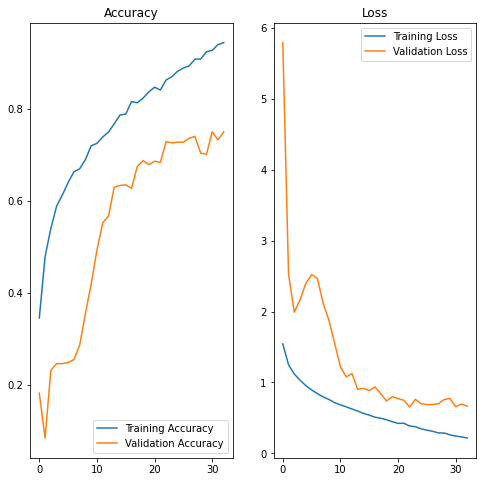

Training Accuracy  : 94.69%     Training loss  : 0.205852
Validation Accuracy: 74.97%     Validation loss: 0.665950
Test Accuracy      : 79.10%     Test loss      : 0.576014


In [56]:
model = create_simple_resnet()
model.compile(optimizer=Adam(lr=0.0001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=100,
    callbacks=[early_stop]
)
plot_training_history(history)
evaluate_model(model)

## Exercise 2
Models often benefit from reducing the learning rate. Slowing down the learning process can help find the local minimum more precisely. This can be done manually (by periodically recompiling the model with a lower learning rate and refining the data) or automatically using `ReduceLROnPlateau` callback. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. 

Implement `ReduceLROnPlateau` callback and compare train and test results.  At which epochs the learning rate was reduced? By looking at the validation loss graph how does validation loss change when the learning rate was reduced?


In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)

Epoch 1/100
25/25 [==============================] - 9s 368ms/step - loss: 1.4282 - accuracy: 0.4375 - val_loss: 3.1377 - val_accuracy: 0.0463 - lr: 5.0000e-04
Epoch 2/100
25/25 [==============================] - 9s 355ms/step - loss: 0.9776 - accuracy: 0.5925 - val_loss: 2.2839 - val_accuracy: 0.1915 - lr: 5.0000e-04
Epoch 3/100
25/25 [==============================] - 9s 355ms/step - loss: 0.8216 - accuracy: 0.6463 - val_loss: 2.9128 - val_accuracy: 0.2028 - lr: 5.0000e-04
Epoch 4/100
25/25 [==============================] - 9s 356ms/step - loss: 0.7329 - accuracy: 0.6950 - val_loss: 2.5479 - val_accuracy: 0.2053 - lr: 5.0000e-04
Epoch 5/100
25/25 [==============================] - 9s 356ms/step - loss: 0.6425 - accuracy: 0.7328 - val_loss: 3.0236 - val_accuracy: 0.1777 - lr: 5.0000e-04
Epoch 6/100
25/25 [==============================] - 9s 356ms/step - loss: 0.5783 - accuracy: 0.7591 - val_loss: 2.4925 - val_accuracy: 0.2403 - lr: 5.0000e-04
Epoch 7/100
25/25 [=====================

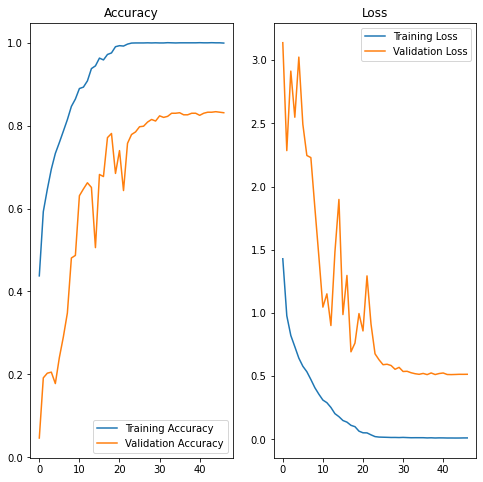

Training Accuracy  : 99.97%     Training loss  : 0.007237
Validation Accuracy: 83.10%     Validation loss: 0.514572
Test Accuracy      : 84.90%     Test loss      : 0.461284


In [58]:
model = create_simple_resnet()
model.compile(optimizer=Adam(lr=0.0005),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)
plot_training_history(history)
evaluate_model(model)

## Exercise 3
Experiment with ResNet architecture. Add more depth and width to the simple model and compare training results. You may use any callbacks if you want.

In [59]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

x = Conv2DWithBatchNorm(inputs, 64, 3, activation='relu', kernel_initializer='he_normal')

x = conv_block(x, [64, 64, 256])
x = identity_block(x, [64, 64, 256])
x = identity_block(x, [64, 64, 256])

x = conv_block(x, [128, 128, 512])
x = identity_block(x, [128, 128, 512])
x = identity_block(x, [128, 128, 512])
x = identity_block(x, [128, 128, 512])

x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = Dense(6)(x)
x = Activation('softmax')(x)

model = Model(inputs, x, name='resnet')

Epoch 1/100
25/25 [==============================] - 25s 990ms/step - loss: 1.3267 - accuracy: 0.4803 - val_loss: 15.9243 - val_accuracy: 0.0451 - lr: 5.0000e-04
Epoch 2/100
25/25 [==============================] - 24s 978ms/step - loss: 0.8135 - accuracy: 0.6616 - val_loss: 5.7414 - val_accuracy: 0.0763 - lr: 5.0000e-04
Epoch 3/100
25/25 [==============================] - 24s 974ms/step - loss: 0.7078 - accuracy: 0.6956 - val_loss: 2.5668 - val_accuracy: 0.2315 - lr: 5.0000e-04
Epoch 4/100
25/25 [==============================] - 24s 976ms/step - loss: 0.5725 - accuracy: 0.7688 - val_loss: 2.8814 - val_accuracy: 0.2528 - lr: 5.0000e-04
Epoch 5/100
25/25 [==============================] - 24s 976ms/step - loss: 0.5106 - accuracy: 0.7906 - val_loss: 2.3879 - val_accuracy: 0.2941 - lr: 5.0000e-04
Epoch 6/100
25/25 [==============================] - 24s 976ms/step - loss: 0.4124 - accuracy: 0.8341 - val_loss: 3.3778 - val_accuracy: 0.3079 - lr: 5.0000e-04
Epoch 7/100
25/25 [==============

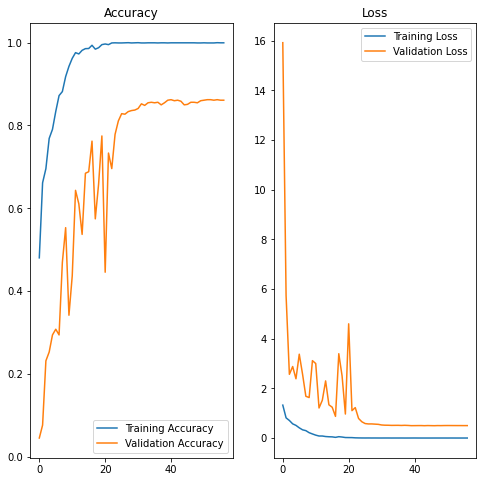

Training Accuracy  : 99.97%     Training loss  : 0.000916
Validation Accuracy: 86.11%     Validation loss: 0.501746
Test Accuracy      : 87.20%     Test loss      : 0.508479


In [60]:
model.compile(optimizer=Adam(lr=0.0005),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)
plot_training_history(history)
evaluate_model(model)

## Exercise 4
**Transfer learning** involves using models trained on one problem as a starting point on a related problem. Transfer learning has the benefit of decreasing the training time for a neural network model and can result in lower generalization error. The weights in re-used layers may be used as the starting point for the training process and adapted in response to the new problem. Keras provides convenient access to many top-performing models on the ImageNet image recognition tasks such as VGG, Inception, and ResNet. When using pre-trained models, developers often leave top layers of the network nontrainable, e. g. they interpret low-level features or shapes that could be reused in a new problem. 

For this exercise, train and evaluate ResNet50 with pre-trained weights `weights='imagenet'`. For best results, you can try making top layers nontrainable.

In [75]:
model_top = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = GlobalAveragePooling2D()(model_top.output)  
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = Dense(6)(x)
x = Activation('softmax')(x)
model =  Model(model_top.input, x, name='resnet50')

In [64]:
for layer in model_top.layers[:135]:  
    layer.trainable = False 
for layer in model_top.layers[135:]:  
    layer.trainable = True  

Epoch 1/100
25/25 [==============================] - 2s 95ms/step - loss: 1.5690 - accuracy: 0.4781 - val_loss: 2.5381 - val_accuracy: 0.1940 - lr: 5.0000e-04
Epoch 2/100
25/25 [==============================] - 2s 61ms/step - loss: 0.9640 - accuracy: 0.6344 - val_loss: 5.8899 - val_accuracy: 0.3091 - lr: 5.0000e-04
Epoch 3/100
25/25 [==============================] - 2s 61ms/step - loss: 0.7153 - accuracy: 0.7225 - val_loss: 5.6348 - val_accuracy: 0.2403 - lr: 5.0000e-04
Epoch 4/100
25/25 [==============================] - 2s 61ms/step - loss: 0.6273 - accuracy: 0.7522 - val_loss: 6.5104 - val_accuracy: 0.2553 - lr: 5.0000e-04
Epoch 5/100
25/25 [==============================] - 2s 61ms/step - loss: 0.5376 - accuracy: 0.7897 - val_loss: 5.8720 - val_accuracy: 0.1289 - lr: 5.0000e-04
Epoch 6/100
25/25 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.8213
Epoch 00006: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
25/25 [======================

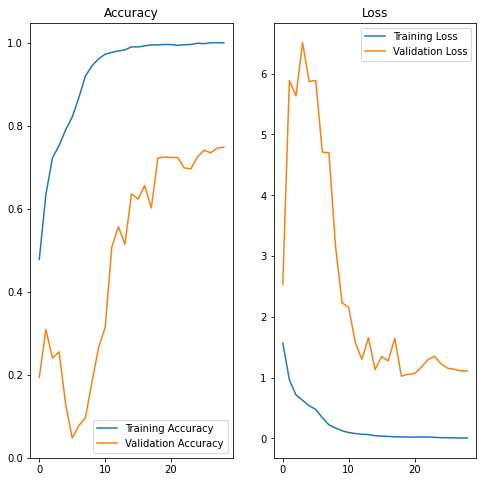

Training Accuracy  : 99.97%     Training loss  : 0.003074
Validation Accuracy: 74.84%     Validation loss: 1.109510
Test Accuracy      : 73.40%     Test loss      : 1.125912


In [65]:
model.compile(optimizer=Adam(lr=0.0005),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit_generator(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)
plot_training_history(history)
evaluate_model(model)

## Exercise 5
Experiment with the full dataset (15k images) or with augmented images on any residual network. How are your results different compared to a small dataset?

In [66]:
url = 'https://storage.googleapis.com/vehicle-dataset/vehicles_full.zip'
path_to_zip = get_file('vehicles_full.zip', origin=url, extract=True)
path = join(dirname(path_to_zip), 'vehicles_full')

In [67]:
augm_image_generator = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=.15,
                                         height_shift_range=.15,
                                         brightness_range=(0.1,0.9),
                                         zoom_range=0.3,
                                         channel_shift_range=150,
                                         horizontal_flip=True,
                                         validation_split=0.2) 